In [1]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import functions notebook and load data set here
import sys
sys.path.append("../")
from time_series_functions import *

In [3]:
df=pd.read_csv('../zillow_data.csv')

In [4]:
df=melt_data2(df)

In [5]:
df.set_index('time',inplace=True)

In [6]:
# Rename RegionName to be Zipcode
df=df.rename({'RegionName':'Zipcode'},axis='columns')

In [7]:
#drop no longer relevant columns
df.drop(['RegionID','SizeRank','City','CountyName'],axis=1,inplace=True)

In [8]:
Arizona_df= df[(df['State'] == 'AZ')]

In [9]:
Arizona_df

,Zipcode,State,Metro,value
time,,,,
1996-04-01,85032,AZ,Phoenix,95400.0
1996-04-01,85710,AZ,Tucson,94600.0
1996-04-01,85225,AZ,Phoenix,101200.0
1996-04-01,85308,AZ,Phoenix,124800.0
1996-04-01,85281,AZ,Phoenix,81200.0
...,...,...,...,...
2018-04-01,86332,AZ,Prescott,172500.0
2018-04-01,85645,AZ,Tucson,152300.0
2018-04-01,85928,AZ,Show Low,225100.0


In [10]:
Arizona_recent_yrs=Arizona_df['2009-01-01':'2018-04-01']

In [11]:
Arizona_recent_yrs

,Zipcode,State,Metro,value
time,,,,
2009-01-01,85032,AZ,Phoenix,190200.0
2009-01-01,85710,AZ,Tucson,171100.0
2009-01-01,85225,AZ,Phoenix,179900.0
2009-01-01,85308,AZ,Phoenix,212000.0
2009-01-01,85281,AZ,Phoenix,181300.0
...,...,...,...,...
2018-04-01,86332,AZ,Prescott,172500.0
2018-04-01,85645,AZ,Tucson,152300.0
2018-04-01,85928,AZ,Show Low,225100.0


In [12]:
Phoenix_data = Arizona_recent_yrs[(Arizona_recent_yrs['Metro'] == 'Phoenix')]

In [13]:
Phoenix_data
Phoenix_data=Phoenix_data.drop(['State','Metro'],axis=1)

In [14]:
top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
(Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
                             (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
                             (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
                             (Phoenix_data['Zipcode'] == 85054)]

In [15]:
def get_zip(zipcode):
    top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
    (Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
                             (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
                            (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
                             (Phoenix_data['Zipcode'] == 85054)]
    zip_zipcode=top_10_zips_phx[top_10_zips_phx['Zipcode']==zipcode]
    #zip_zipcode.drop(['index'],axis=1,inplace=True)
    zip_zipcode.reset_index(inplace=True)
    
    # shift by one period (month)
    resampled_shift_1 = zip_zipcode[['value']].shift(1)
    resampled_shift_1.bfill(inplace=True)

#reset the indexes to perform calculation of growth
    top_10_zips_phx = zip_zipcode.reset_index()
    resampled_shift_1 = resampled_shift_1.reset_index()

#Growth Calculation
    zip_zipcode['growth'] = (zip_zipcode['value'] - resampled_shift_1['value'])/(resampled_shift_1['value'])
    zip_zipcode['growth']= abs(zip_zipcode['growth'])
#set the index back to zipcode and time multi-index
    zip_zipcode.set_index(['time'],inplace=True)
    
    zip_zipcode.drop('Zipcode',axis=1,inplace=True)
    data= top_10_zips_phx
    print(f'The stationarity check for zipcode {zipcode} before adjustments:{stationarity_check(zip_zipcode.growth)}')
    
    #Original Plot
    fig, ax = plt.subplots()
    ax.plot(zip_zipcode.growth)
    ax.set_title(f"Original Zipcode Plot for {zipcode}");
    
    #log values and dropna
    log_zipcode= abs(np.log(zip_zipcode.growth))
    log_zipcode.dropna(inplace=True)
    
    # get roll mean and subtract
    roll_mean = log_zipcode.rolling(window=7,center=False).mean()
    data_minus_roll_mean = log_zipcode-roll_mean
    
    #Drop missing values
    data_minus_roll_mean.dropna(inplace=True)
    return data_minus_roll_mean
    #Plot the data minus roll mean
    #data_minus_roll_mean.plot(figsize=(10,6));
    fig, ax = plt.subplots()
    ax.plot(data_minus_roll_mean)
    ax.set_title(f"Final Zipcode Plot for {zipcode}");

    print(f'The stationarity check for zipcode {zipcode}, after adjustments:{stationarity_check(data_minus_roll_mean)}')
    


Results of Dickey-Fuller Test: 

Test Statistic                  -4.505804
p-value                          0.000192
#Lags Used                       3.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64
The stationarity check for zipcode 85255 before adjustments:None


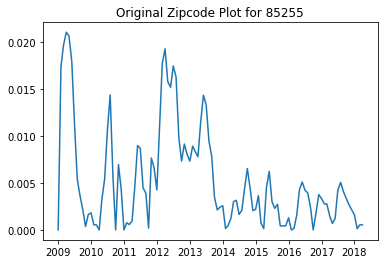

In [16]:
minus_roll_mean=get_zip(85255)

In [17]:
minus_roll_mean

time
2009-08-01    1.017764
2009-09-01    1.193272
2009-10-01    1.385909
2009-11-01    2.595458
2009-12-01    0.729271
                ...   
2017-12-01    0.328093
2018-01-01    0.655763
2018-02-01    2.648396
2018-03-01    0.941704
2018-04-01    0.651394
Name: growth, Length: 75, dtype: float64

In [18]:
# find the index which allows us to split off 20% of the data
cutoff = round(minus_roll_mean.shape[0]*0.8)
cutoff

60

In [19]:
# Define train and test sets according to the index found above
train = minus_roll_mean[:cutoff]

test = minus_roll_mean[cutoff:]

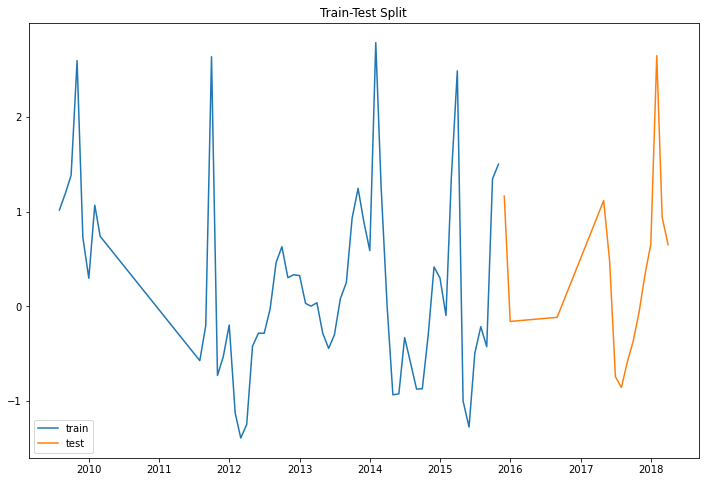

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [21]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[0 1 2 3 4 5 6 7 8 9] [10 11 12 13 14 15 16 17 18 19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [20 21 22 23 24 25 26 27 28 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] [30 31 32 33 34 35 36 37 38 39]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] [40 41 42 43 44 45 46 47 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] [50 51 52 53 54 55 56 57 58 59]


In [22]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
baseline = train.shift(1)
baseline

time
2009-08-01         NaN
2009-09-01    1.017764
2009-10-01    1.193272
2009-11-01    1.385909
2009-12-01    2.595458
2010-01-01    0.729271
2010-02-01    0.297915
2010-03-01    1.069204
2011-08-01    0.740854
2011-09-01   -0.571836
2011-10-01   -0.202702
2011-11-01    2.636775
2011-12-01   -0.728642
2012-01-01   -0.530778
2012-02-01   -0.195622
2012-03-01   -1.124738
2012-04-01   -1.389244
2012-05-01   -1.245863
2012-06-01   -0.419533
2012-07-01   -0.282423
2012-08-01   -0.283035
2012-09-01   -0.021721
2012-10-01    0.465494
2012-11-01    0.631107
2012-12-01    0.304038
2013-01-01    0.334702
2013-02-01    0.325539
2013-03-01    0.032192
2013-04-01    0.002904
2013-05-01    0.038911
2013-06-01   -0.281262
2013-07-01   -0.442718
2013-08-01   -0.299097
2013-09-01    0.082452
2013-10-01    0.252280
2013-11-01    0.932338
2013-12-01    1.246627
2014-01-01    0.893528
2014-02-01    0.589700
2014-03-01    2.784943
2014-04-01    1.251902
2014-05-01    0.003448
2014-06-01   -0.933205
2014-0

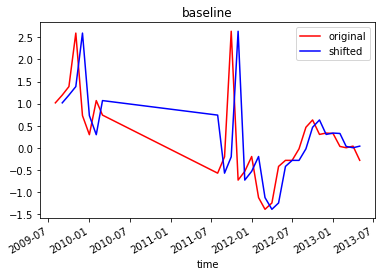

In [23]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
baseline[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('baseline')
ax.legend();

In [24]:
np.sqrt(mean_squared_error(train[1:], baseline.dropna()))

1.0187048845011675

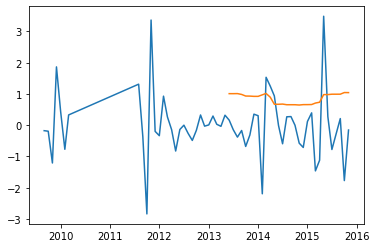

In [25]:
fig, ax = plt.subplots()
residuals = baseline[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

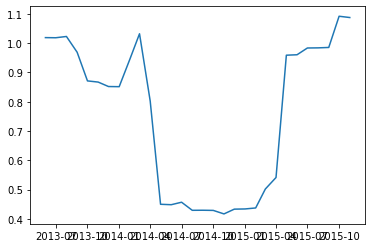

In [26]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

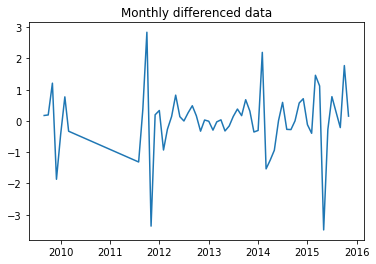

In [27]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Monthly differenced data');

In [28]:
p_val = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 2.0007734261054305e-14,
 so we can safely assume that the differenced data is stationary.


In [29]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

time
2009-08-01    0.000000
2009-09-01    1.017764
2009-10-01    1.156877
2009-11-01    1.345961
2009-12-01    2.344632
2010-01-01    1.116265
2010-02-01    0.387366
2010-03-01    0.909261
2011-08-01    0.808945
2011-09-01   -0.299621
2011-10-01   -0.279250
2011-11-01    2.047948
2011-12-01   -0.030750
2012-01-01   -0.571809
2012-02-01   -0.265123
2012-03-01   -0.932065
2012-04-01   -1.334393
2012-05-01   -1.275596
2012-06-01   -0.590890
2012-07-01   -0.310855
2012-08-01   -0.282908
2012-09-01   -0.075911
2012-10-01    0.364460
2012-11-01    0.596764
2012-12-01    0.371863
2013-01-01    0.328343
2013-02-01    0.327440
2013-03-01    0.093024
2013-04-01    0.008978
2013-05-01    0.031444
2013-06-01   -0.214867
2013-07-01   -0.409236
2013-08-01   -0.328880
2013-09-01    0.003330
2013-10-01    0.217063
2013-11-01    0.791314
2013-12-01    1.181452
2014-01-01    0.966751
2014-02-01    0.652705
2014-03-01    2.329712
2014-04-01    1.569811
2014-05-01    0.262342
2014-06-01   -0.738969
2014-0

In [30]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   60
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -83.492
Date:                Tue, 04 Jan 2022   AIC                            170.985
Time:                        18:13:11   BIC                            175.140
Sample:                             0   HQIC                           172.607
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2074      0.104     -1.988      0.047      -0.412      -0.003
sigma2         0.9917      0.143      6.957      0.000       0.712       1.271
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                14.87
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.40
Prob(H) (two-sided):                  0.95   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   60
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -84.811
Date:                Tue, 04 Jan 2022   AIC                            171.622
Time:                        18:13:11   BIC                            173.699
Sample:                             0   HQIC                           172.433
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0377      0.116      8.959      0.000       0.811       1.265
===================================================================================
Ljung-Box (L1) (Q):                   2.76   Jarque-Bera (JB):                35.90
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.80
Prob(H) (two-sided):                  0.64   Kurtosis:                         6.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Random Walk AIC: 171.62153465733684
AR(1, 1, 0) AIC: 170.98459037156545


In [33]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.996202125169786

In [34]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

1.018689214875648

In [35]:
train.index

DatetimeIndex(['2009-08-01', '2009-09-01', '2009-10-01', '2009-11-01',
               '2009-12-01', '2010-01-01', '2010-02-01', '2010-03-01',
               '2011-08-01', '2011-09-01', '2011-10-01', '2011-11-01',
               '2011-12-01', '2012-01-01', '2012-02-01', '2012-03-01',
               '2012-04-01', '2012-05-01', '2012-06-01', '2012-07-01',
               '2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01',
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
      

In [36]:
train_with_ind = train.reset_index()

In [37]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.0853307938673153
0.5333040412282409
1.2862591199360995
2.157106072005572
1.1920528858041926


In [38]:
ar_1.arparams

array([-0.20737176])

In [39]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1, 1), train[1:].diff().dropna())
print(lr.coef_)

[-0.21081806]


In [40]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

time
2009-08-01    0.000000
2009-09-01    1.017764
2009-10-01    1.156262
2009-11-01    1.256035
2009-12-01    2.155517
2010-01-01    0.785821
2010-02-01    1.197092
2010-03-01    1.017526
2011-08-01    0.520179
2011-09-01   -0.045120
2011-10-01    0.229395
2011-11-01    1.638303
2011-12-01   -0.898477
2012-01-01    0.800035
2012-02-01   -0.377192
2012-03-01   -0.986308
2012-04-01   -0.926749
2012-05-01   -1.179355
2012-06-01   -0.724952
2012-07-01   -0.664513
2012-08-01   -0.339473
2012-09-01   -0.099328
2012-10-01    0.212415
2012-11-01    0.380564
2012-12-01    0.333099
2013-01-01    0.460631
2013-02-01    0.315606
2013-03-01    0.123380
2013-04-01    0.132770
2013-05-01    0.040277
2013-06-01   -0.200734
2013-07-01   -0.262394
2013-08-01   -0.275215
2013-09-01   -0.090541
2013-10-01    0.044116
2013-11-01    0.659580
2013-12-01    0.872149
2014-01-01    0.868949
2014-02-01    0.826041
2014-03-01    2.256327
2014-04-01    0.802141
2014-05-01    1.008509
2014-06-01   -0.138569
2014-0

In [41]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

171.62153465733684
170.98459037156545
162.20462262663636


In [42]:
y_hat_ar1 = ar_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.9081086026335173

In [43]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.04945487854132
0.5618360007916524
1.2381809197067244
1.991023995341528
1.1844636908706911


### Moving Avg

In [44]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

time
2009-08-01    0.222736
2009-09-01    0.551433
2009-10-01    0.542809
2009-11-01    0.661840
2009-12-01    1.241552
2010-01-01   -0.048049
2010-02-01    0.405772
2010-03-01    0.573820
2011-08-01    0.311136
2011-09-01   -0.244569
2011-10-01    0.244894
2011-11-01    1.488627
2011-12-01   -0.950742
2012-01-01    0.445000
2012-02-01   -0.116310
2012-03-01   -0.310969
2012-04-01   -0.347935
2012-05-01   -0.252488
2012-06-01    0.134329
2012-07-01    0.002173
2012-08-01    0.071791
2012-09-01    0.173245
2012-10-01    0.377408
2012-11-01    0.357005
2012-12-01    0.194703
2013-01-01    0.296830
2013-02-01    0.237931
2013-03-01    0.113850
2013-04-01    0.164019
2013-05-01    0.156524
2013-06-01   -0.008959
2013-07-01   -0.006828
2013-08-01    0.068055
2013-09-01    0.230356
2013-10-01    0.234339
2013-11-01    0.592149
2013-12-01    0.569116
2014-01-01    0.394430
2014-02-01    0.326082
2014-03-01    1.524076
2014-04-01    0.078689
2014-05-01    0.182915
2014-06-01   -0.367965
2014-0

In [45]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   60
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -76.058
Date:                Tue, 04 Jan 2022   AIC                            158.115
Time:                        18:13:12   BIC                            164.398
Sample:                             0   HQIC                           160.573
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2227      0.206      1.081      0.279      -0.181       0.626
ma.L1          0.5292      0.125      4.224      0.000       0.284       0.775
sigma2         0.7348      0.112      6.589      0.000       0.516       0.953
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 8.78
Prob(Q):                              0.87   Prob(JB):                         0.01
Heteroskedasticity (H):               0.69   Skew:                             0.54
Prob(H) (two-sided):                  0.41   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
ma_1 = ARIMA(train, order=(0, 1, 1)).fit()

print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

171.62153465733684
170.98459037156545
162.20462262663636
166.39544247861093


In [47]:
y_hat_ar1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.9572609490196358

In [48]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.1108728844167366
0.710145471392925
1.1852281692903526
1.9243979141612912
1.2057115325785752


In [49]:
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

time
2009-08-01    0.000000
2009-09-01    1.017764
2009-10-01    1.168226
2009-11-01    1.280161
2009-12-01    2.179617
2010-01-01    0.582338
2010-02-01    1.023152
2010-03-01    1.184208
2011-08-01    0.873788
2011-09-01    0.159295
2011-10-01    0.626993
2011-11-01    2.054150
2011-12-01   -0.645879
2012-01-01    0.800867
2012-02-01    0.140749
2012-03-01   -0.120691
2012-04-01   -0.241591
2012-05-01   -0.197224
2012-06-01    0.180273
2012-07-01    0.021331
2012-08-01    0.079024
2012-09-01    0.175814
2012-10-01    0.395712
2012-11-01    0.383351
2012-12-01    0.216499
2013-01-01    0.325426
2013-02-01    0.264495
2013-03-01    0.131320
2013-04-01    0.178121
2013-05-01    0.165235
2013-06-01   -0.016816
2013-07-01   -0.027005
2013-08-01    0.040043
2013-09-01    0.205696
2013-10-01    0.209956
2013-11-01    0.593765
2013-12-01    0.585095
2014-01-01    0.417899
2014-02-01    0.353371
2014-03-01    1.630334
2014-04-01    0.145170
2014-05-01    0.263873
2014-06-01   -0.332635
2014-0

In [50]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

171.62153465733684
170.98459037156545
162.20462262663636
166.39544247861093
159.82845080869336


In [51]:
y_hat_ar1 = ma_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.8938828278341543

In [52]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.2609059295852805
0.7100964369165291
1.1724455961518334
2.014089495713934
1.2540308096872754


### ARMA

In [53]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

In [54]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

171.62153465733684
170.98459037156545
162.20462262663636
166.39544247861093
159.82845080869336
165.45684849932186


In [55]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [56]:
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))

1.018689214875648
0.996202125169786
0.9081086026335173
0.9572609490196358
0.8938828278341543
0.9027607614823612


In [57]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.087999797713997
0.39758656705459067
1.271867426890948
2.447438111581005
1.1538608506495536


In [58]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [59]:
print(find_rmse_test(random_walk_model))
print(find_rmse_test(ar_1))
print(find_rmse_test(ar_2))
print(find_rmse_test(ma_1))
print(find_rmse_test(ma_2))
print(find_rmse_test(arma_21))

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'